In [63]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os.path
import random

import tensorflow as tf
import tensorflow.keras as keras

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from skimage import exposure, filters, io, morphology, transform
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential

In [90]:
try:
  ran == True
    
except:
  # path2 = kagglehub.dataset_download("alessiocorrado99/animals10")

  # print("Path to dataset files:", path)
  ran = True
else:
    try:
        print(path2)
    except:
       print("path2")


C:\Users\Natanael\.cache\kagglehub\datasets\alessiocorrado99\animals10\versions\2\raw-img


In [46]:
# set the path to the dataset and the path to the images folder
path = 'C:\\Users\\Natanael\\.cache\\kagglehub\\datasets\\alessiocorrado99\\animals10\\versions\\2'
path = path + '\\raw-img'
# path = Path(path)
path

'C:\\Users\\Natanael\\.cache\\kagglehub\\datasets\\alessiocorrado99\\animals10\\versions\\2\\raw-img'

In [17]:
# https://www.kaggle.com/code/vencerlanz09/animal-image-classification-using-efficientnetb7?scriptVersionId=125017960&cellId=11

def convert_path_to_df(dataset):
    """
    Convert image paths to a DataFrame

    Args:
        dataset: str, path to the dataset

    Returns:
        image_df: DataFrame, contains filepaths and labels

    """
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(path)

In [47]:
# Check for corrupted images within the dataset
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(path).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)
print("Done")

Done


Label
ragno         5143
cane          4863
gallina       3098
cavallo       2623
farfalla      2534
pecora        2196
gatto         2108
mucca         1866
scoiattolo    1862
elefante      1805
Name: count, dtype: int64

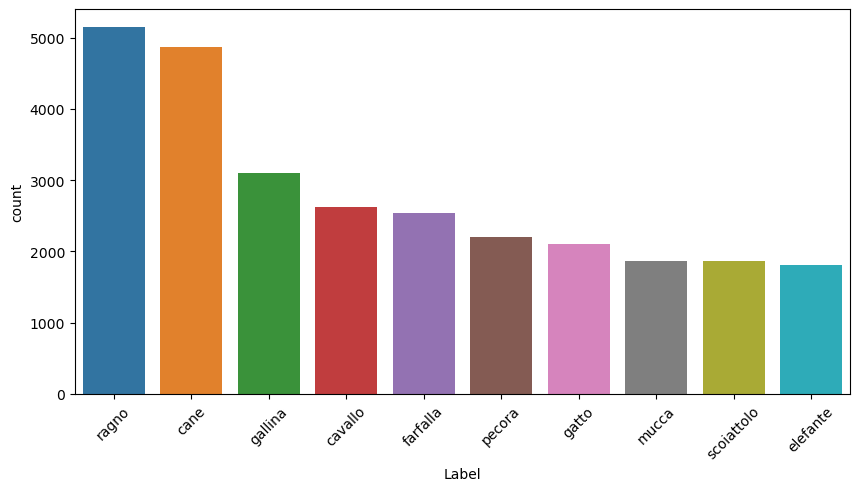

In [60]:
# Display the number of images per class
display(image_df.value_counts('Label'))

labels = image_df['Label'].value_counts()

plt.figure(figsize=(10, 5))
sns.barplot(x=labels.index, y=labels, hue=labels.index )
plt.xticks(rotation=45)
plt.show()

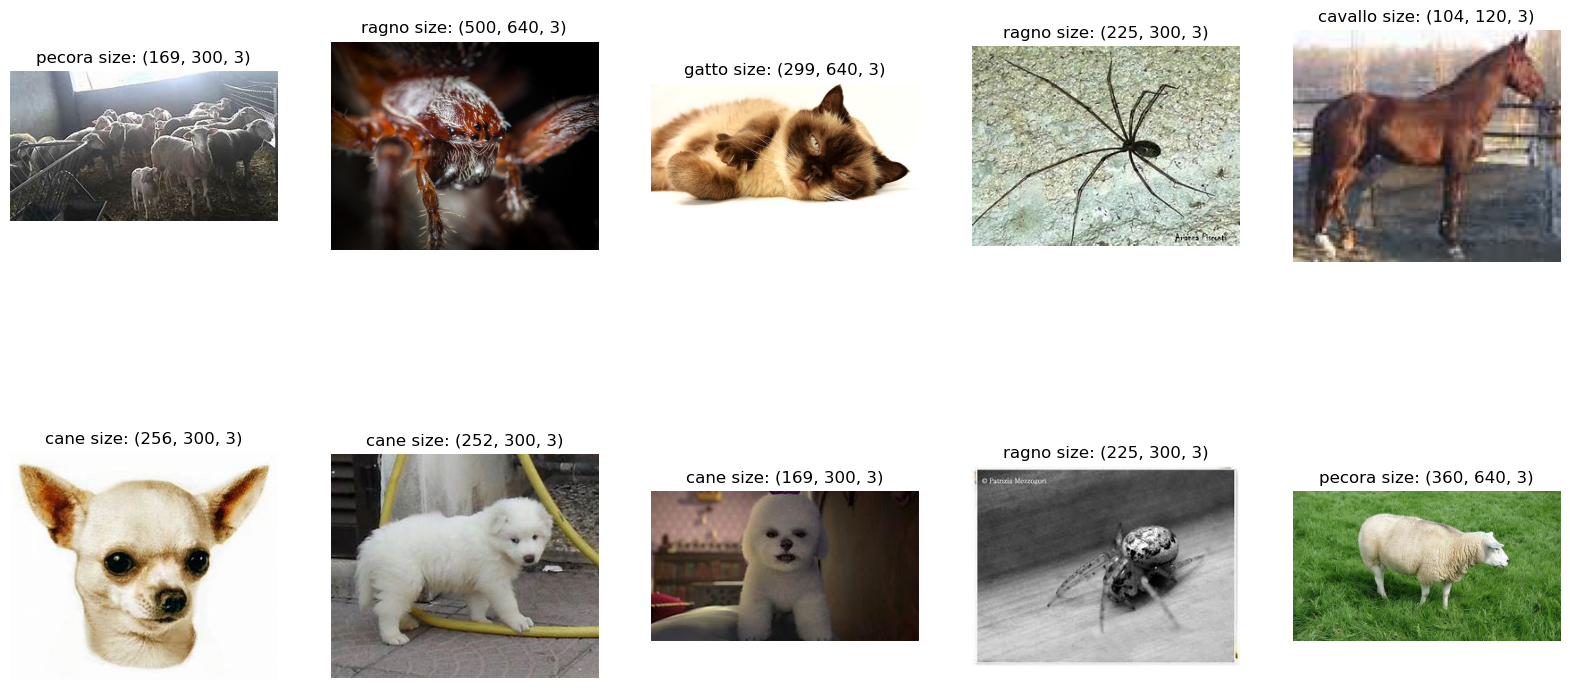

In [85]:
#  open 10 random images in image_df, with path in column 'Filepath', with respective labels and sizes
random.seed(42)
random_range = random.sample(range(0, len(image_df)), 10)
plt.figure(figsize=(20, 10))
for i in random_range:
    plt.subplot(2, 5, random_range.index(i)+1)
    img = io.imread(image_df['Filepath'][i])
    plt.title(f"{image_df['Label'][i]} size: {img.shape}")
    plt.imshow(img)
    plt.axis('off')
plt.show()


In [62]:
# look for the smallest, largest, and average image in the dataset
min_shape = (np.inf, np.inf)
max_shape = (0, 0)
total_shape = (0, 0)
for i in range(len(image_df)):
    img = io.imread(image_df['Filepath'][i])
    if img.shape[0] < min_shape[0]:
        min_shape = img.shape
    if img.shape[0] > max_shape[0]:
        max_shape = img.shape

print(f"Smallest image shape: {min_shape}")
print(f"Largest image shape: {max_shape}")


Smallest image shape: (57, 60, 3)
Largest image shape: (6000, 3798, 3)


TypeError: unsupported operand type(s) for /: 'tuple' and 'int'

In [92]:
# Define image size
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Create an ImageDataGenerator for data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load and preprocess images
def preprocess_image(image_path):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = tf.expand_dims(image, 0)  # Add batch dimension
    return image

def full_preprocess(image_path):
  preprocessed_image = preprocess_image(image_path)
  preprocessed_image = datagen.flow(preprocessed_image, batch_size=1)[0]

  return preprocessed_image

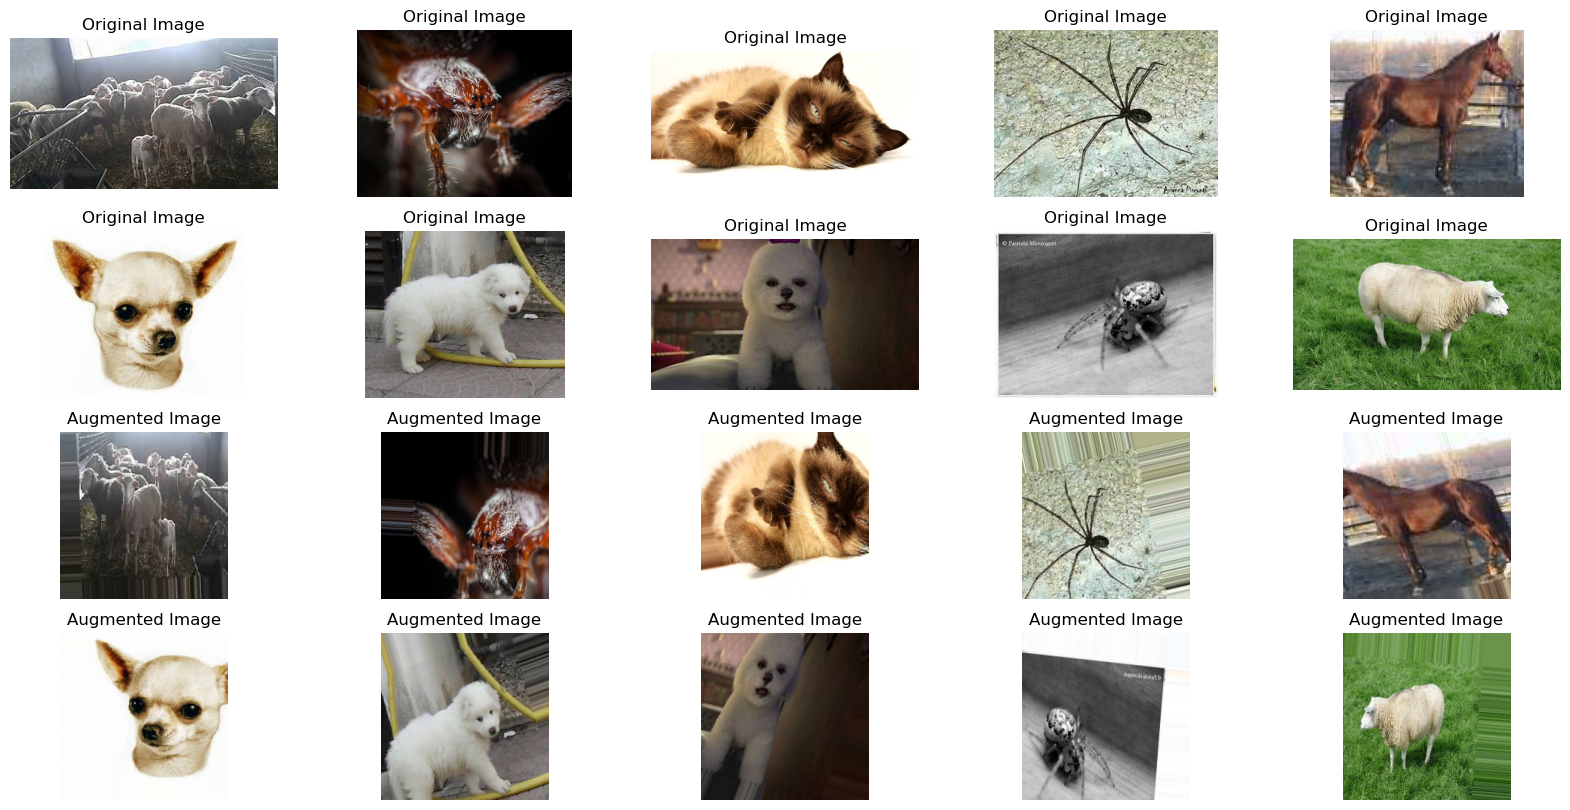

In [88]:
# Example usage
# random_range = random.sample(range(0, len(image_df)), 10)
plt.figure(figsize=(20, 10))
for i in random_range:
    image_path = image_df['Filepath'][i]
    preprocessed_image = preprocess_image(image_path)
    preprocessed_image = datagen.flow(preprocessed_image, batch_size=1)[0]

    plt.subplot(4, 5, random_range.index(i)+1)
    plt.title('Original Image')
    plt.imshow(io.imread(image_path))
    plt.axis('off')

    plt.subplot(4, 5, random_range.index(i)+11)
    plt.title('Augmented Image')
    #put preprocessed image in grayscale
    # preprocessed_image = tf.image.rgb_to_grayscale(preprocessed_image)
    plt.imshow(preprocessed_image[0], cmap='gray')
    plt.axis('off')

plt.show()

# a

In [103]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, shuffle=True, random_state=42)

In [106]:
# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    # validation_split=0.2  # Use 20% of data for validation
)

# Only rescaling for validation and test data
valid_test_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    # validation_split=0.2  # Use 20% of data for validation
    )

In [107]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical',
    # batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    # subset='training', 
    color_mode='rgb'
)

validation_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42,
    # subset='validation',
    color_mode='rgb'
)

test_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    color_mode='rgb'
)

Found 17982 validated image filenames belonging to 10 classes.
Found 4496 validated image filenames belonging to 10 classes.
Found 5620 validated image filenames belonging to 10 classes.


# CNN

In [ ]:
# create a cnn model for image classification (10 classes)
def create_model():
    model = models.Sequential()
    model.add(Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))

    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))

    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))

    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    # model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
def model2():
  model = models.Sequential()
  model.add(Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)))

  model.add(layers.Conv2D(32, kernel_size=(3, 3), activation="relu")),
  model.add(layers.Conv2D(32, kernel_size=(3, 3), activation="relu")),

  model.add(layers.MaxPooling2D(pool_size=(2, 2))),

  model.add(layers.Conv2D(64, kernel_size=(3, 3), activation="relu")),
  model.add(layers.Conv2D(64, kernel_size=(3, 3), activation="relu")),

  model.add(layers.MaxPooling2D(pool_size=(2, 2))),

  model.add(layers.Conv2D(64, kernel_size=(3, 3), activation="relu")),

  model.add(layers.MaxPooling2D(pool_size=(2, 2))),

  model.add(layers.Flatten()),
  model.add(layers.Dropout(0.5)),

  model.add(layers.Dense(10, activation="softmax"))

  model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
  return model
# 0.41 accuracy xdd (solo 3 epochs)

In [ ]:
cnn = create_model()
cnn.summary()

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

history = cnn.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=3,
    batch_size = BATCH_SIZE,
    callbacks=[early_stopping, model_checkpoint],
    verbose = 1,
    optimizers = 'adam'
)

# model fitting

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=10
)